# 3 Body Modelling - 2D


Notebook for 3 body modelling calculations that are to be developed into N body calculations.

In [1]:
# Import requirements
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

In [2]:
# Function that will be passed into the ode to update
# spatial coordinates and velocites of 3 bodies

def ThreeBodyFunction(t, r):
    
    dr = np.zeros(12)
    
    # Abritrary value for G and the masses of the bodies. Masses setup to produce
    # elliptical orbits of 2 light bodies around a more massive one

    G = 1
    m1 = 1
    m2 = 1
    m3 = 3000
    
    xpos1 = r[0]
    xvel1 = r[1]
    ypos1 = r[2]
    yvel1 = r[3]
    xpos2 = r[4]
    xvel2 = r[5]
    ypos2 = r[6]
    yvel2 = r[7]
    xpos3 = r[8]
    xvel3 = r[9]
    ypos3 = r[10]
    yvel3 = r[11]
    
    # We need 3 equations for the distance between bodies as we need the
    # distance between 1 and 2, 1 and 3, and 2 and 3.

    r_12 = ((xpos1-xpos2)**2 + (ypos1-ypos2)**2)**0.5
    r_13 = ((xpos1-xpos3)**2 + (ypos1-ypos3)**2)**0.5
    r_23 = ((xpos2-xpos3)**2 + (ypos2-ypos3)**2)**0.5

    # Set of coupled differential equations for ode to solve

    dxpos1 = xvel1
    dr[0] = dxpos1

    dxvel1 =  (-G*m2*(xpos1-xpos2))*(r_12)**(-3) + (-G*m3*(xpos1-xpos3))*(r_13)**(-3)
        
    dr[1] = dxvel1

    dypos1 = yvel1
    dr[2] = dypos1

    dyvel1 = (-G*m2*(ypos1-ypos2))*(r_12)**(-3) + \
        (-G*m3*(ypos1-ypos3))*(r_13)**(-3)
    dr[3] = dyvel1

    dxpos2 = xvel2
    dr[4] = dxpos2

    dxvel2 = (-G*m1*(xpos2-xpos1))*(r_12)**(-3) + \
        (-G*m3*(xpos2-xpos3))*(r_23)**(-3)
    dr[5] = dxvel2

    dypos2 = yvel2
    dr[6] = dypos2

    dyvel2 = (-G*m1*(ypos2-ypos1))*(r_12)**(-3) + \
        (-G*m3*(ypos2-ypos3))*(r_23)**(-3)
    dr[7] = dyvel2

    dxpos3 = xvel3
    dr[8] = dxpos3

    dxvel3 = (-G*m1*(xpos3-xpos1))*(r_13)**(-3) + \
        (-G*m2*(xpos3-xpos2))*(r_23)**(-3)
    dr[9] = dxvel3

    dypos3 = yvel3
    dr[10] = dypos3

    dyvel3 = (-G*m1*(ypos3-ypos1))*(r_13)**(-3) + \
        (-G*m2*(ypos3-ypos2))*(r_23)**(-3)
    dr[11] = dyvel3
        
    return dr

In [3]:
# Initial Conditions of 3 bodies (2 light, 1 massive)

# 2 light bodies
xpos1, ypos1, xvel1, yvel1 = 50, 0, 0, 10
xpos2, ypos2, xvel2, yvel2 = -50, 0, 0, -10

# More massive body
xpos3, ypos3, xvel3, yvel3 = 0, 0, 0, 0

initial1 = [xpos1, xvel1, ypos1, yvel1];
initial2 = [xpos2, xvel2, ypos2, yvel2];
initial3 = [xpos3, xvel3, ypos3, yvel3];

initial = initial1 + initial2 + initial3

In [4]:
# Setup time interval and steps to iterate over
t0 = 0
t1 = 250
t = np.linspace(t0, t1, 1000)

# Array for solution
y = np.zeros((len(t), 12))
y[0, :] = initial

# Setup integrator
r = integrate.ode(ThreeBodyFunction) \
        .set_integrator('dopri5', rtol=1e-6, atol=1e-10, nsteps=100) \
        .set_initial_value(initial, t0) 

# Iterate over time intervals and integrate
for i in range(1, t.size):
    # Store updated spatial coordinates and velocities of bodies
    y[i, :] = r.integrate(t[i])

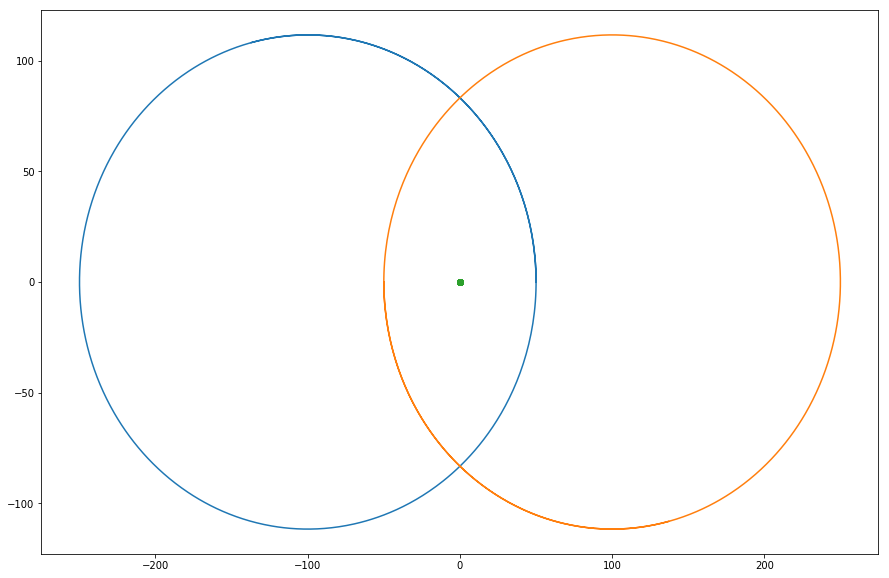

In [5]:
# Plot results
plt.figure(figsize=(15,10))
plt.plot(y[:, 0], y[:, 2])
plt.plot(y[:, 4], y[:, 6])
plt.plot(y[:, 8], y[:, 10], 'o')
plt.show()